In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

In [2]:
import os
from os import path
import torch
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

In [3]:
from Pytorch.utils import Denormalize_tensor, Show_figure_with_bbox
from Pytorch.Datasets.ROIDataset import ROI_DATASET
from Pytorch.Models.ROIClassifier import M_ROI_CLASSIFIER

In [4]:
exp_name = "COCO-ROIClassification-RN50-SGD-IMSize472"
epochs = 120
batch_size = 12
num_batch_train = 180
num_batch_val = 60
img_size = 472

In [5]:
parameters_path = path.join("parameters", exp_name)
plots_path = path.join("plots", exp_name)

In [6]:
DSET_training = ROI_DATASET(
    root_dirpath =  '../../../Datasets/COCO',
    images_dirpath = '../../../Datasets/COCO/train2017',
    annotations_path = '../../../Datasets/COCO/annotations/instances_train2017.json',
    F_image_id_to_relative_path = lambda image_id: "{:012d}.jpg".format(image_id),
    augmentation = True,
    batch_size = batch_size,
    num_batch = num_batch_train,
    desired_size = img_size,
)

In [7]:
DSET_validation = ROI_DATASET(
    root_dirpath = '../../../Datasets/COCO',
    images_dirpath = '../../../Datasets/COCO/val2017',
    annotations_path = '../../../Datasets/COCO/annotations/instances_val2017.json',
    F_image_id_to_relative_path = lambda image_id: "{:012d}.jpg".format(image_id),
    augmentation = False,
    batch_size = batch_size,
    num_batch = num_batch_val,
    desired_size = img_size,
)

{'supercategory': 'sports', 'id': 35, 'name': 'skis'}

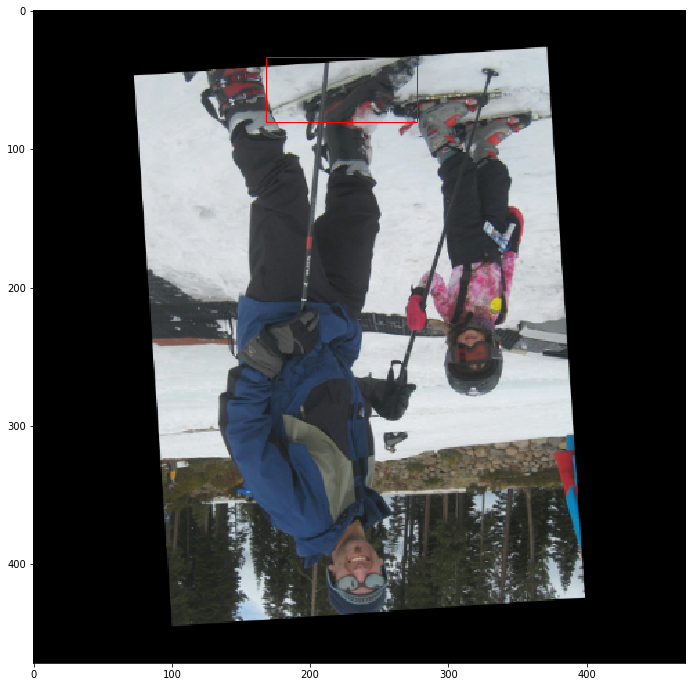

In [8]:
(T_img, T_bbox), class_idx = DSET_training[0]
denormalize_func = Denormalize_tensor(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
T_normal_img = denormalize_func(T_img)
Show_figure_with_bbox(transforms.ToPILImage()(T_normal_img), (T_img.shape[1:3]), T_bbox.numpy())
DSET_training.Get_class_idx_description(class_idx)

{'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'}

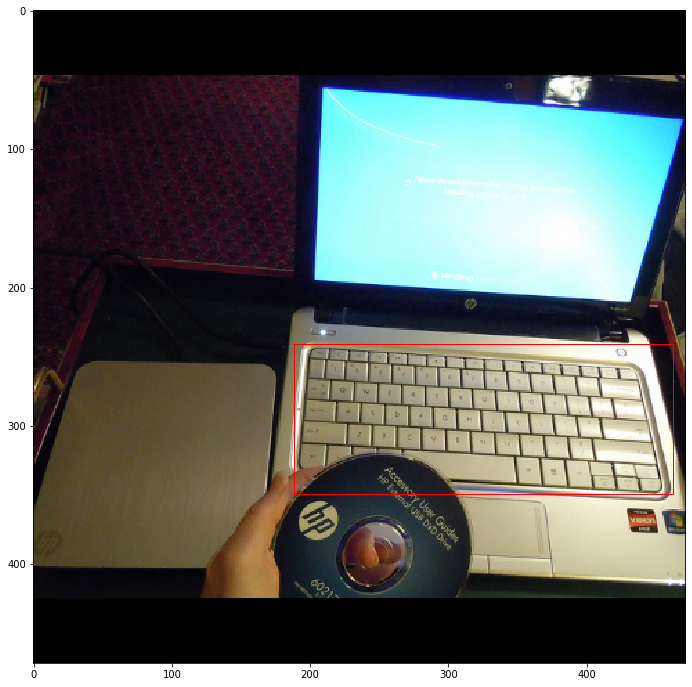

In [9]:
(T_img, T_bbox), class_idx = DSET_validation[0]
denormalize_func = Denormalize_tensor(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
T_normal_img = denormalize_func(T_img)
Show_figure_with_bbox(transforms.ToPILImage()(T_normal_img), (T_img.shape[1:3]), T_bbox.numpy())
DSET_training.Get_class_idx_description(class_idx)

In [10]:
DL_training = DataLoader(DSET_training, batch_size=batch_size, shuffle=False)
DL_validation = DataLoader(DSET_validation, batch_size=batch_size, shuffle=False)

In [11]:
M_roi_classifier = M_ROI_CLASSIFIER(num_classes=DSET_training.Get_num_classes())
M_roi_classifier = M_roi_classifier.to('cuda')

In [12]:
def prepare_batch_fn(batch, gt):
    gt = gt.long()
    return batch, gt

In [13]:
from torchtrainer.trainer import Trainer, Mode
from torchtrainer.callbacks.calculateaccuracycallback import CalculateTopNAccuracyCallback
from torchtrainer.callbacks.calculatelosscallback import CalculateLossCallback
from torchtrainer.callbacks.plotcallback import PlotCallback
from torchtrainer.callbacks.saveparameterscallback import SaveParametersCallback
from torchtrainer.callbacks.settqdmbardescription import SetTQDMBarDescription
from torchtrainer.callbacks.lrbatchschedulercallback import LRBatchSchedulerCallBack

In [14]:
optimizer = torch.optim.SGD(M_roi_classifier.parameters(), lr=0.005, momentum=0.2)
criterion = torch.nn.CrossEntropyLoss()

In [15]:
trainer = Trainer(
    device = 'cuda',
    modes = [Mode.TRAIN, Mode.EVALUATE],
    model = M_roi_classifier,
    data_loaders = {Mode.TRAIN : DL_training, Mode.EVALUATE : DL_validation},
    epochs = epochs,
    starting_epoch = 0,
    optimizer = optimizer,
    criterion = criterion,
    prepare_batch_fn = prepare_batch_fn,
    callbacks = [
        CalculateLossCallback(key='Loss'),
        CalculateTopNAccuracyCallback(keys=('Top-1 accuracy',), topk=(1,)),
        PlotCallback(plots_path, labels_map={Mode.TRAIN:"Train", Mode.EVALUATE:"Val"}, columns=['Loss', 'Top-1 accuracy']),
        SetTQDMBarDescription(keys=['Loss', 'Top-1 accuracy']),
        SaveParametersCallback(parameters_path),
    ]
)

In [ ]:
trainer.start()

Epoch 0


Loss = 2.7477 Top-1 accuracy = 34.7222 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 1



Loss = 2.1745 Top-1 accuracy = 42.7778 : 100%|██████████| 60/60 [01:49<00:00,  1.82s/it]

Epoch 2



Loss = 2.0817 Top-1 accuracy = 46.3889 : 100%|██████████| 60/60 [01:47<00:00,  1.78s/it]

Epoch 3



Loss = 2.0836 Top-1 accuracy = 45.6944 : 100%|██████████| 60/60 [01:48<00:00,  1.81s/it]

Epoch 4



Loss = 1.8443 Top-1 accuracy = 48.4722 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 5



Loss = 1.8471 Top-1 accuracy = 52.5000 : 100%|██████████| 60/60 [01:47<00:00,  1.79s/it]

Epoch 6



Loss = 1.6841 Top-1 accuracy = 55.6944 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 7



Loss = 1.9630 Top-1 accuracy = 45.6944 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 8



Loss = 1.8163 Top-1 accuracy = 51.3889 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 9



Loss = 1.7813 Top-1 accuracy = 53.3333 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 10



Loss = 1.7156 Top-1 accuracy = 53.4722 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 11



Loss = 1.8022 Top-1 accuracy = 51.1111 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 12



Loss = 1.7310 Top-1 accuracy = 51.5278 : 100%|██████████| 60/60 [01:47<00:00,  1.79s/it]

Epoch 13



Loss = 1.5434 Top-1 accuracy = 58.1944 : 100%|██████████| 60/60 [01:46<00:00,  1.77s/it]


Epoch 14


Loss = 1.5006 Top-1 accuracy = 58.1944 : 100%|██████████| 60/60 [01:47<00:00,  1.79s/it]

Epoch 15



Loss = 1.5840 Top-1 accuracy = 58.0556 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 16



Loss = 1.4697 Top-1 accuracy = 60.0000 : 100%|██████████| 60/60 [01:49<00:00,  1.83s/it]

Epoch 17



Loss = 1.4011 Top-1 accuracy = 62.6389 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 18



Loss = 1.5138 Top-1 accuracy = 56.9444 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 19



Loss = 1.4340 Top-1 accuracy = 59.8611 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 20



Loss = 1.4048 Top-1 accuracy = 59.7222 : 100%|██████████| 60/60 [01:47<00:00,  1.79s/it]

Epoch 21



Loss = 1.4123 Top-1 accuracy = 61.6667 : 100%|██████████| 60/60 [01:46<00:00,  1.78s/it]

Epoch 22



Loss = 1.6629 Top-1 accuracy = 54.8611 : 100%|██████████| 60/60 [01:47<00:00,  1.79s/it]

Epoch 23



Loss = 2.0886 Top-1 accuracy = 41.6667 :   2%|▏         | 4/180 [00:20<15:07,  5.16s/it]

In [17]:
from torch_lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


In [18]:
criterion = torch.nn.CrossEntropyLoss()


Learning rate search finished. See the graph with {finder_name}.plot()


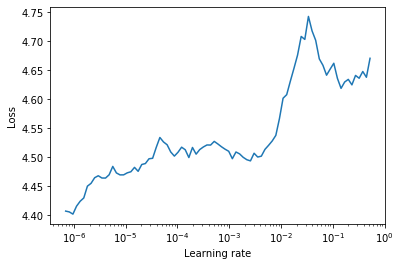

In [19]:
optimizer = torch.optim.SGD(M_roi_classifier.parameters(), lr=1e-7, momentum=0.0)
lr_finder = LRFinder(M_roi_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


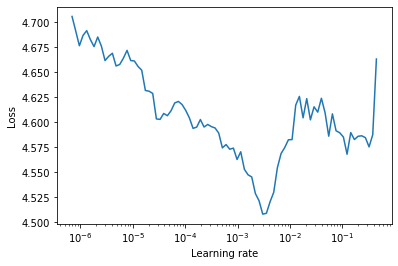

In [20]:
optimizer = torch.optim.SGD(M_roi_classifier.parameters(), lr=1e-7, momentum=0.2)
lr_finder = LRFinder(M_roi_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


Learning rate search finished. See the graph with {finder_name}.plot()


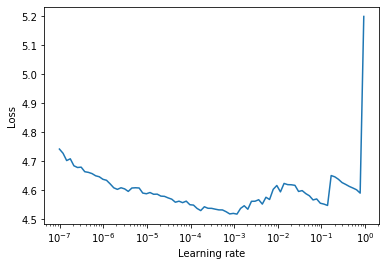

In [21]:
optimizer = torch.optim.SGD(M_roi_classifier.parameters(), lr=1e-8, momentum=0.8)
lr_finder = LRFinder(M_roi_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [22]:
optimizer = torch.optim.Adam(M_roi_classifier.parameters())
lr_finder = LRFinder(M_roi_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

RuntimeError: CUDA out of memory. Tried to allocate 328.00 MiB (GPU 0; 11.17 GiB total capacity; 10.31 GiB already allocated; 19.31 MiB free; 10.84 GiB reserved in total by PyTorch) (malloc at /opt/conda/conda-bld/pytorch_1587428266983/work/c10/cuda/CUDACachingAllocator.cpp:289)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x4e (0x7fbab4684b5e in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1f39d (0x7fbab444639d in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x2058e (0x7fbab444758e in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #3: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x291 (0x7fba6a092741 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #4: <unknown function> + 0xdccb8b (0x7fba68342b8b in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xe16477 (0x7fba6838c477 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xdd3999 (0x7fba92f0e999 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #7: <unknown function> + 0xdd3cd7 (0x7fba92f0ecd7 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0xd67a9e (0x7fba682dda9e in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #9: <unknown function> + 0xd6a563 (0x7fba682e0563 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #10: at::native::cudnn_convolution_backward_input(c10::ArrayRef<long>, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long, bool, bool) + 0xb2 (0x7fba682e0da2 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #11: <unknown function> + 0xdd18c0 (0x7fba683478c0 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #12: <unknown function> + 0xe16158 (0x7fba6838c158 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #13: at::native::cudnn_convolution_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long, bool, bool, std::array<bool, 2ul>) + 0x4fa (0x7fba682e243a in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #14: <unknown function> + 0xdd1beb (0x7fba68347beb in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #15: <unknown function> + 0xe161b4 (0x7fba6838c1b4 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #16: <unknown function> + 0x29defc6 (0x7fba94b19fc6 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #17: <unknown function> + 0x2a2ea54 (0x7fba94b69a54 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #18: torch::autograd::generated::CudnnConvolutionBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x378 (0x7fba94731f28 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0x2ae8215 (0x7fba94c23215 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #20: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 0x16f3 (0x7fba94c20513 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #21: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&, bool) + 0x3d2 (0x7fba94c212f2 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #22: torch::autograd::Engine::thread_init(int) + 0x39 (0x7fba94c19969 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #23: torch::autograd::python::PythonEngine::thread_init(int) + 0x38 (0x7fba97d5e558 in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #24: <unknown function> + 0xc819d (0x7fbacfda719d in /home/torrisicalanna/miniconda3/lib/python3.7/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6)
frame #25: <unknown function> + 0x76db (0x7fbad2ddb6db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #26: clone + 0x3f (0x7fbad2b0488f in /lib/x86_64-linux-gnu/libc.so.6)
